## Create a Model to find the best spot for my skate session

My goal for this project is to build the best machine learning model to help me find the best skatepark for my session, according of the week day, the weather, temperature and the traffic time.
Montréal has 14 skateparks, sometimes it's hard for me to choose the best spot.
The input will be:
 -  the weather (of course, I don't want to skate outside if it snows...)
 -  the temperature 
 -  the traffic time (Sometimes the traffic at Montréal is a nightmare)
 - I also gave a general grade for the skatepark..

## Connexion to the S3 bucket and get the data:

In [1]:
import os, boto3, random
import pandas as pd
from botocore.exceptions import ClientError
from io import StringIO
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

2025-11-07 00:43:24.998692: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 00:43:25.018393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 00:43:25.731762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 00:43:28.139794: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Get Data from S3:

For the model, as it's a simple regression, we can just give as a input 1 spot index, and not the 14 skatespots.
The time to do all the inference will not be a problem, it's not a critical system.
It will be easier to me to add skateparks, Montreal build new one, in the future.

In [3]:
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="us-east-1"
)

In [4]:
BUCKET_NAME = "skatedata"          # ton bucket
FILE_KEY = "skatepark_dataset_test.csv"  # ton fichier CSV

obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

print(df.head())

     spot_name  index spot  weather  temperature  traffic_time  weekday  \
0     Ahuntsic           0        3         15.8           5.0        1   
1     VanHorne           1        3         15.8           5.0        1   
2       Verdun           2        3         15.8           5.0        1   
3      Lasalle           3        3         15.8           5.0        1   
4  Préfontaine           4        3         15.8           5.0        1   

   park_score  satisfaction  
0         8.0           9.0  
1         4.0           2.0  
2         2.0           1.0  
3         8.5           9.0  
4         8.5           8.0  


## Generator:


In [5]:
random.seed(1)

INPUTS_COLS = ["weather", "temperature", "traffic_time", "weekday", "park_score"]
OUTPUT_COL =  "satisfaction"
TRAINING_PERCENTAGE = 90



dataset = [
                [row[INPUTS_COLS].tolist(), row[OUTPUT_COL]]
                for _, row in df.iterrows()
            ]
random.shuffle(dataset)

split_idx = int(TRAINING_PERCENTAGE / 100 * len(dataset))
train_dataset = dataset[:split_idx]
val_dataset = dataset[split_idx:]


import numpy as np

def generator(part_dataset, batch_size=4):
    X_batch, y_batch = [], []

    while True:
        for X, y in part_dataset:
            X_batch.append(X)
            y_batch.append(y)

            if len(X_batch) == batch_size:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
                X_batch, y_batch = [], []

        if X_batch:
            yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
            X_batch, y_batch = [], []


## Model Architecture:

First Model tested will be 5 Dense Layers.

In [6]:
INPUT_DIM = 5
OUTPUT_DIM = 1

model = models.Sequential([
    layers.Input(shape = (INPUT_DIM,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(OUTPUT_DIM, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',            
    metrics=['mae']        
)

model.summary()

2025-11-07 00:43:35.908118: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,657 (26.00 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 0 (0.00 B)

## Training:

In [7]:
EPOCHS = 300
BATCHSIZE = 4

training_gen   = generator(train_dataset, BATCHSIZE)
validation_gen = generator(val_dataset, BATCHSIZE)

steps_per_epoch = len(train_dataset) // BATCHSIZE
validation_steps = len(val_dataset) // BATCHSIZE

history = model.fit(
    training_gen,
    validation_data=validation_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS
)


Epoch 1/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4886 - mae: 2.6159 - val_loss: 9.9740 - val_mae: 2.5388
Epoch 2/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5218 - mae: 2.5024 - val_loss: 11.1674 - val_mae: 2.8408
Epoch 3/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1169 - mae: 2.4233 - val_loss: 11.9800 - val_mae: 3.0644
Epoch 4/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0273 - mae: 2.4224 - val_loss: 11.2044 - val_mae: 3.0218
Epoch 5/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8978 - mae: 2.3784 - val_loss: 8.6479 - val_mae: 2.6107
Epoch 6/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7038 - mae: 2.3564 - val_loss: 9.5276 - val_mae: 2.7096
Epoch 7/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4346 - mae: 2.3064 - val_loss: 10.4865 - val_mae: 2.8914
Epoch 8/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4039 - mae: 2.3102 - val_loss: 11.1845 - val_mae: 3.0571
Epoch 9/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

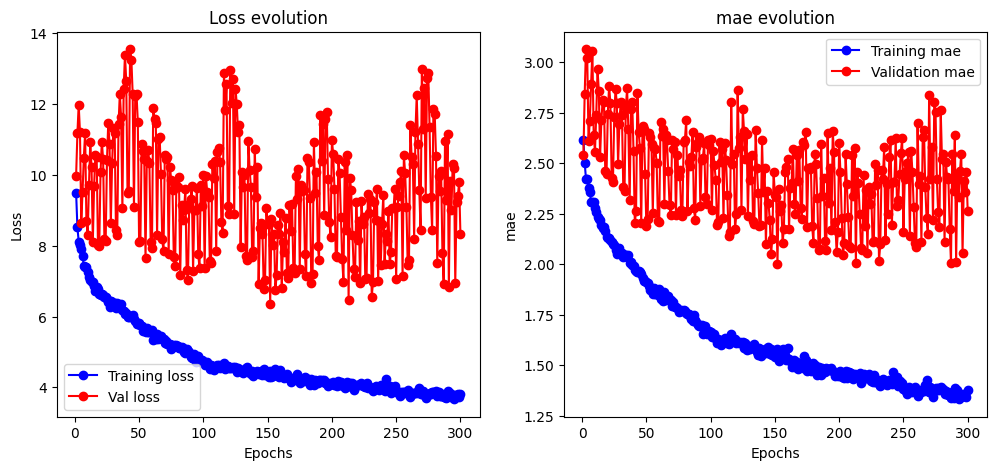

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history.get('mae')
val_mae = history.history.get('val_mae')

epochs = range(1, EPOCHS + 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label = "Training loss")
plt.plot(epochs, val_loss, 'ro-', label = "Val loss")

plt.title("Loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae, 'bo-', label='Training mae')
plt.plot(epochs, val_mae, 'ro-', label="Validation mae")
plt.title( "mae evolution")
plt.xlabel('Epochs')
plt.ylabel("mae")
plt.legend()
plt.show()

### Observation:
No generalisation on the learning. The Loss of the training seems to converge but the validation didn't during the training...
Few causes:
- the dataset is too noisy
- useless input such as skatepark grade

We will take this notebook and do some modifications to it to train a new model with revelant inputs.


## Test and Validation:

In [8]:
skateparks_dict = {
    "Ahuntsic": 8,
    "VanHorne": 4,
    "Verdun": 2,
    "Lasalle": 8.5,
    "Préfontaine": 8.5,
    "Boucherville": 7,
    "Taz": 7,
    "Spin": 6.5,
    "Saint Jérome": 8,
    "Saint Sauveur": 8.5,
    "Assomption": 8.5,
    "Benny": 8,
    "Dorval": 8,
    "Magog": 9.5,
    "Berthierville": 9.5
}


days_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wenesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

# Weather: 
# Rain or Snow  = 0
# Clouds + Wind = 1
# Clouds        = 2
# Blue sky      = 3

weather_dict = {
    0: "Rain or Snow",
    1: "Windy or heavily cloudy",
    2: "cloudy",
    3: "Blue sky"
}

In [9]:
# INPUTS_COLS = ["weather", "temperature", "traffic_time", "weekday", "park_score"]

# Test 1:
input_test = [ 0, 1.0, 20, 6, 8]


input_test_array = np.array([input_test]) 

prediction = model.predict(input_test_array)
print(prediction)


# Test 2:
input_test = [ 0, 3.0, 20, 6, 8]


input_test_array = np.array([input_test]) 

prediction = model.predict(input_test_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[1.7132496]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[1.6457745]]


## Interpretation:
#### Test1:
Going to a 8/0 skatepark with snow or rain is with a satisfaction of 1.7 /10 => Coherent

#### Test2:
Going to a 8/0 skatepark with a blue sky give us a satisfaction of 1.64/10 => Less that if we have a rainy weather ( test1)... Incoherent
